# Crossover with moving average

![](https://mcd.unison.mx/wp-content/themes/awaken/img/logo_mcd.png)

## Forecasting assisted by TDA (Topological Data Analysis)    

## Subject: Time Series and Topological Data Analysis

## Master Degree in Data Science
Teachers:
**Rosalía Guadalupe Hernadez Amador** and **Jesús Francisco Espinoza Fierro**, 2022

**Student: jose Luis Bracamonte Amavizca**

Goal: Know and implement tools for topological data analysis  for forecasting and classification of time series.

[Open in  Google Colab](https://colab.research.google.com/github/luisjba/time-series/blob/master/TDA_forecasting.ipynb)

### Import libraries

In [13]:
%matplotlib inline
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd
from statsmodels.tsa.seasonal import seasonal_decompose
import seaborn as sns
import sqlite3
import os
plt.style.use('ggplot')
mpl.style.use("seaborn")
plt.rcParams['figure.figsize'] = (20,10)
# extra import for interactive plot!
from ipywidgets import interact
import ts

# I : Time Series Forecasting

The goal for this work is to use Finance Time Series data of cryptocurrency for exploring and applying different techniques 
for Forecasting in Time Series Data. 

Binance is a cryptocurrency exchanger who have available different cryptos to buy/trade having available the most
pupular 

For our convenience,  we are going to connect to Binance API using a python library.

## 1.1 Forecasting in Financial Time Series

### Access and download for finance time series data.

#### 1 - Installation of **Binance** python library

To install the Binance Python Library, you can use pip command as follows


```bash
pip install python-binance 
```

After the libraries are installed, we should be able to import them.

In [3]:
from binance import Client, ThreadedWebsocketManager, ThreadedDepthCacheManager

#### 2 - Authenticate using credentials

For this project, we were provided by a set of key for educational purpose, please do not missuses them.

In [4]:
api_key="XBwBZYhuhmGGpF5qAzJXx7bX64Wh8sQBSoDkA4orYnSs5ttQ6i0nFuCxPOgoUjh9"
api_secret="YWV39SS9wgTJfVFmBN5mjS5QHfsiZ9l0XLEMDP3mreMgjNpIjuDKvYrT5aFYiNY7"

#### 3 - Binance function exploration

Here we are going to explore the main available functions in order to identify which information can be downloaded using the Binance API. 

In [5]:
# Create the client using the key and secret
client = Client(api_key, api_secret)

Get all symbols and prices, printing the total of prices found.

In [7]:
prices = client.get_all_tickers()
print(f'Total of prices: {len(prices):0,}')

Total of prices: 2,129


Print the first 5 elements to examine the data structure.

In [8]:
print("First 5 prices")
print(prices[:5])

First 5 prices
[{'symbol': 'ETHBTC', 'price': '0.07531100'}, {'symbol': 'LTCBTC', 'price': '0.00460800'}, {'symbol': 'BNBBTC', 'price': '0.01777600'}, {'symbol': 'NEOBTC', 'price': '0.00040800'}, {'symbol': 'QTUMETH', 'price': '0.00172900'}]


We can see each price item contains a `symbol`and  `price` attributes.

As I am familiar with ETH (Ethereum) cryptocurrency, we are going to filter that symbol form the prices.

In [11]:
eth_prices = [x for x in prices if "ETHUSD" in x["symbol"]]
print(f'Total of ETH prices found: {len(eth_prices)}')
eth_prices

Total of ETH prices found: 3


[{'symbol': 'ETHUSDT', 'price': '1271.86000000'},
 {'symbol': 'ETHUSDC', 'price': '1338.12000000'},
 {'symbol': 'ETHUSDP', 'price': '1344.37000000'}]

Exploring the [Binance REST API documentation](https://github.com/binance/binance-spot-api-docs/blob/master/rest-api.md#klinecandlestick-data), we can found a time series data called *klines* which contains a JSON format with data items,  each kline item have the following format:

```json
[
  [
    1499040000000,      // Kline open time
    "0.01634790",       // Open price
    "0.80000000",       // High price
    "0.01575800",       // Low price
    "0.01577100",       // Close price
    "148976.11427815",  // Volume
    1499644799999,      // Kline Close time
    "2434.19055334",    // Quote asset volume
    308,                // Number of trades
    "1756.87402397",    // Taker buy base asset volume
    "28.46694368",      // Taker buy quote asset volume
    "0"                 // Unused field, ignore.
  ]
]
```
In the columns 0,1,2,3 and 4 we can find the open time, open price, high price and low price, respectively. 

**Note**
The time data is in Unix Time format, thats mean we should consider to convert the time in the Time Zone and with a readable human format.

Four our convenience we have created the function `timestamp2datetime` in the `ts/utils.py` and accessible in the `ts` module. The function contains the following code to convert timestamp to datetime.
```python
def timestamp2datetime(time_stamp:int, tz_hour_dif:int=-7) -> datetime.datetime:
    """Converts timestamp to datetime using a Time Zone"""
    dt = datetime.datetime.fromtimestamp(time_stamp/1000, datetime.timezone.utc)
    delta_hour = datetime.timedelta(hours=abs(tz_hour_dif))
    if tz_hour_dif == 0:
        return dt
    elif tz_hour_dif < 0:
        return dt - delta_hour
    else:
        return dt + delta_hour
```

Just testing the function, we can use the open time `1499040000000` and print different time formats:

In [14]:
open_time = 1499040000000
time_format="%d/%m/%Y %H:%M:%S"
open_time_dt = ts.timestamp2datetime(open_time,0)
open_time_dt_tz_m7 = ts.timestamp2datetime(open_time,-7)
open_time_dt_default_tz = ts.timestamp2datetime(open_time)
print("Open time: ", open_time_dt.strftime(time_format))
print("Open time TZ-7 (Mountain Time): ", open_time_dt_tz_m7.strftime(time_format))
print("Open time Default: ", open_time_dt_default_tz.strftime(time_format))

Open time:  03/07/2017 00:00:00
Open time TZ-7 (Mountain Time):  02/07/2017 17:00:00
Open time Default:  02/07/2017 17:00:00


We can see the default time Zone for the function is TZ-7 (Mountain Time or Hermosillo/Sonora).

#### 4 - Downloading data from Binance API

Now is time to download some kline data from the Binance API, we should use the `client` object and call the function
`get_historical_klines` which accepts different parameters as `symbol`, `interval` and other advanced ones used to make
advanced query for data retrieval.

To retrieve 1 day of data with 1 minute as interval for `ETHUSDT` we can use the next code:

In [15]:
klines_minute_1day = client.get_historical_klines("ETHUSDT", Client.KLINE_INTERVAL_1MINUTE, "1 day ago UTC")

In [19]:
print(f'Total of rows: {len(klines_minute_1day)}')
first_row, last_row = klines_minute_1day[0], klines_minute_1day[-1]
print(f'First row -> open time:{ts.timestamp2datetime(first_row[0])}, open:{first_row[1]}, close:{first_row[4]}')
print(f'Last row -> open time:{ts.timestamp2datetime(last_row[0])}, open:{last_row[1]}, close:{last_row[4]}')

Total of rows: 1440
First row -> open time:2022-11-29 01:48:00+00:00, open:1214.38000000, close:1215.34000000
Last row -> open time:2022-11-30 01:47:00+00:00, open:1269.26000000, close:1269.62000000


Retrieving all klines (from 1 Jan, 2017) with a weekly interval:

In [20]:
klines_weekly_all = client.get_historical_klines("ETHUSDT", Client.KLINE_INTERVAL_1WEEK, "1 Jan, 2017")

In [21]:
print(f'Total of rows: {len(klines_weekly_all)}')
first_row, last_row = klines_weekly_all[0], klines_weekly_all[-1]
print(f'First row -> open time:{ts.timestamp2datetime(first_row[0])}, open:{first_row[1]}, close:{first_row[4]}')
print(f'Last row -> open time:{ts.timestamp2datetime(last_row[0])}, open:{last_row[1]}, close:{last_row[4]}')

Total of rows: 277
First row -> open time:2017-08-13 17:00:00+00:00, open:301.13000000, close:299.10000000
Last row -> open time:2022-11-27 17:00:00+00:00, open:1193.88000000, close:1268.10000000


#### 5 - Candle stick Data visualization of Binance financial data.

For data visualization we are going to use `mplfinance` and `plotly` python libraries. You can install both libraries with:

```bash
# install mplfinance
pip install --upgrade mplfinance

# install plotly
pip install plotly==5.11.0
```
Here we can find the documentation for [mplfincance](https://github.com/matplotlib/mplfinance#newapi) and [plotly](https://plotly.com/python/candlestick-charts/) .


Before to start using the libraries for Candlestik Charts, we should prepare the data and convert it to a pandas dataframe and identifying the data columns, perform a data exploration, format and cleaning.

In [22]:
columns = ["open_time","open","high","low","close","volume","close_time","quote_asset_volume","trades_count",
"taker_buy_base_asset_volume","taker_buy_quote_asset_volume","unused"]

In [23]:
df = pd.DataFrame(klines_weekly_all, columns=columns)

In [24]:
df.head()

,open_time,open,high,low,close,volume,close_time,quote_asset_volume,trades_count,taker_buy_base_asset_volume,taker_buy_quote_asset_volume,unused
0,1502668800000,301.13000000,312.18000000,278.00000000,299.10000000,21224.89324000,1503273599999,6376472.29413210,14013,17401.68830000,5241738.30398570,0
1,1503273600000,299.10000000,348.13000000,144.21000000,348.13000000,45233.88589000,1503878399999,14567413.97749310,42362,17326.14006000,5564163.03804730,0
2,1503878400000,348.11000000,394.39000000,320.08000000,341.77000000,33886.41427000,1504483199999,12290734.08941820,35671,11020.64303000,4002945.64036210,0
3,1504483200000,339.29000000,344.55000000,235.55000000,293.50000000,35485.23332000,1505087999999,10710999.66284450,33803,17117.15948000,5150514.59499200,0
4,1505088000000,293.51000000,316.46000000,192.00000000,257.55000000,58259.63439000,1505692799999,14998281.40081560,44796,23594.05524000,6122996.35882500,0


In [25]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 277 entries, 0 to 276
Data columns (total 12 columns):
 #   Column                        Non-Null Count  Dtype 
---  ------                        --------------  ----- 
 0   open_time                     277 non-null    int64 
 1   open                          277 non-null    object
 2   high                          277 non-null    object
 3   low                           277 non-null    object
 4   close                         277 non-null    object
 5   volume                        277 non-null    object
 6   close_time                    277 non-null    int64 
 7   quote_asset_volume            277 non-null    object
 8   trades_count                  277 non-null    int64 
 9   taker_buy_base_asset_volume   277 non-null    object
 10  taker_buy_quote_asset_volume  277 non-null    object
 11  unused                        277 non-null    object
dtypes: int64(3), object(9)
memory usage: 26.1+ KB


To prepare the data as Time Series, we should convert the time columns.

In [26]:
df["open_time"] = pd.to_datetime(df["open_time"]/1000, unit="s")
df["close_time"] = pd.to_datetime(df["close_time"]/1000, unit="s")

Some of the columns that are numeric should be converted as numeric.

In [27]:

numeric_columns = ["open", "high", "low", "close","volume","quote_asset_volume","taker_buy_base_asset_volume","taker_buy_quote_asset_volume"]
df[numeric_columns] = df[numeric_columns].apply(pd.to_numeric)

In [28]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 277 entries, 0 to 276
Data columns (total 12 columns):
 #   Column                        Non-Null Count  Dtype         
---  ------                        --------------  -----         
 0   open_time                     277 non-null    datetime64[ns]
 1   open                          277 non-null    float64       
 2   high                          277 non-null    float64       
 3   low                           277 non-null    float64       
 4   close                         277 non-null    float64       
 5   volume                        277 non-null    float64       
 6   close_time                    277 non-null    datetime64[ns]
 7   quote_asset_volume            277 non-null    float64       
 8   trades_count                  277 non-null    int64         
 9   taker_buy_base_asset_volume   277 non-null    float64       
 10  taker_buy_quote_asset_volume  277 non-null    float64       
 11  unused                        27

Now, we have to set the `open_time` column as index. 

In [29]:
df.set_index('open_time', inplace=True)

##### 5.1 - Candlestick Charts with mplfinance

We have to import the library and then use the basic plot function, passing the dataframe and specify some labels and title.

In [31]:
import mplfinance as fplt

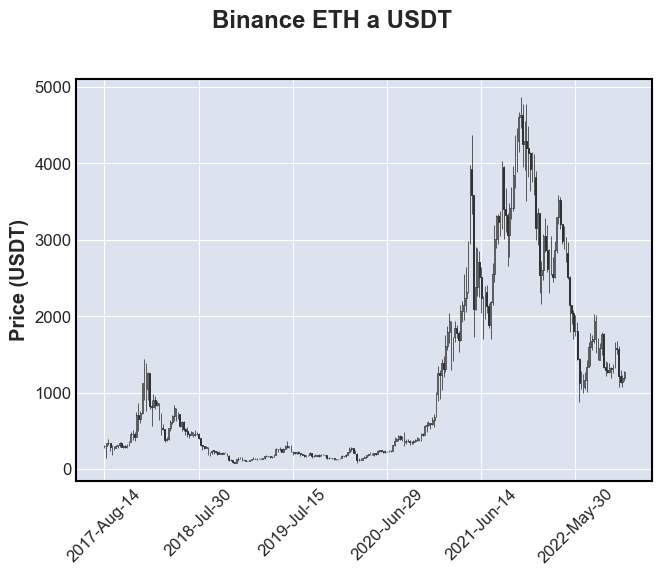

In [32]:
fplt.plot(
            df,
            type='candle',
            title='Binance ETH a USDT',
            ylabel='Price (USDT)'
        )

To have a better visualization, we can make a zoom in the data to have a better visualization of the candlesticks.

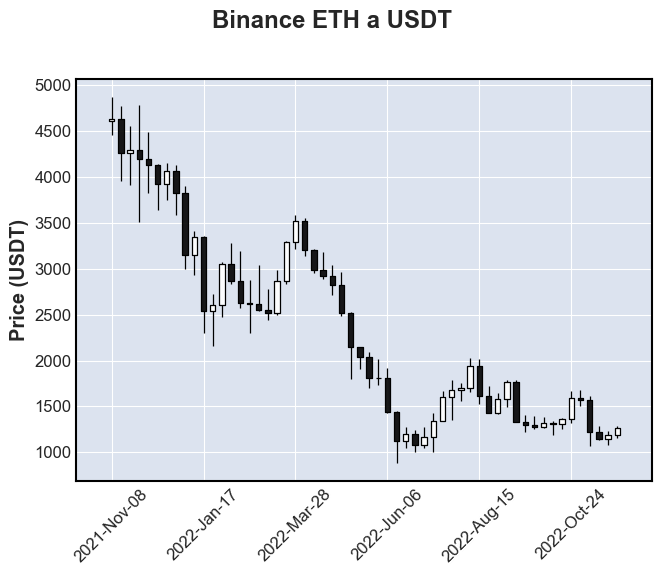

In [33]:
fplt.plot(
            df[-56:],
            type='candle',
            title='Binance ETH to USDT',
            ylabel='Price (USDT)'
        )

The `mplfinance` library have some styles (binance, blueskies, brasil, charles, checkers, etc.) that can be used to modify the look and feel of the chart. We have prepared a script code to iterate and plot all the available styles.

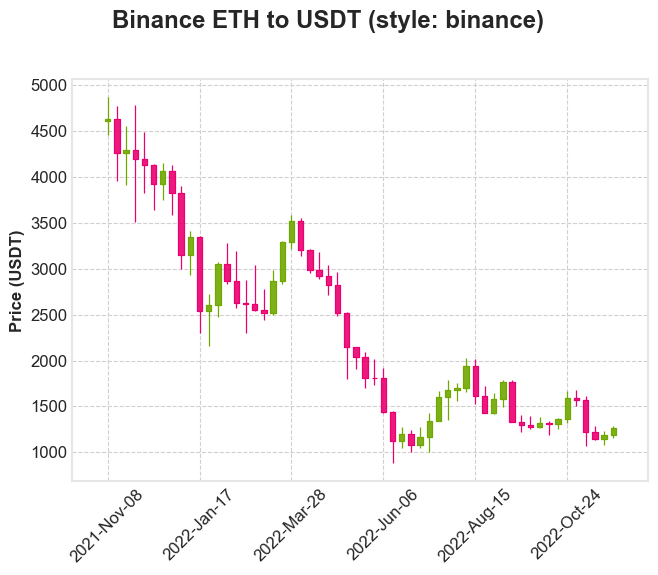

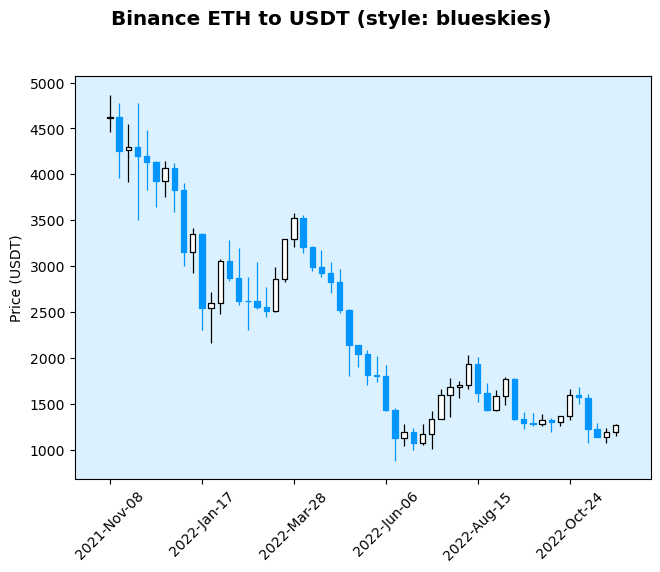

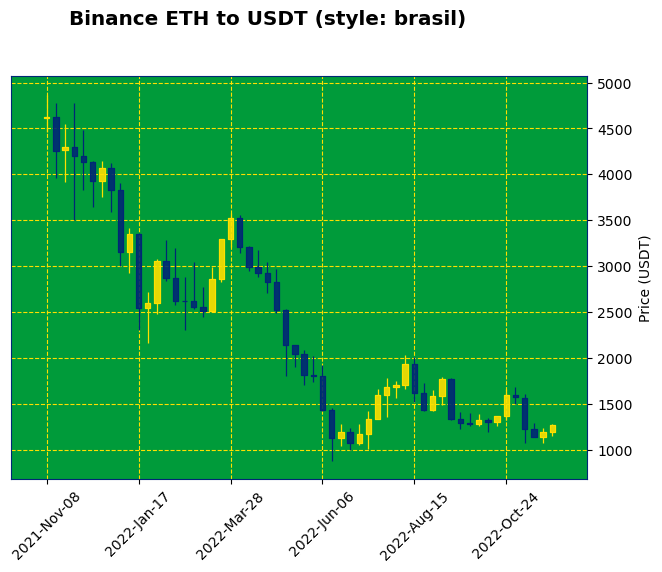

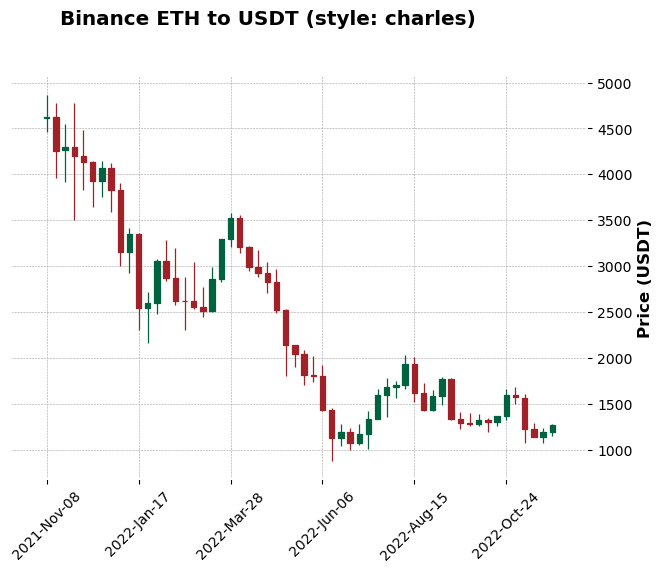

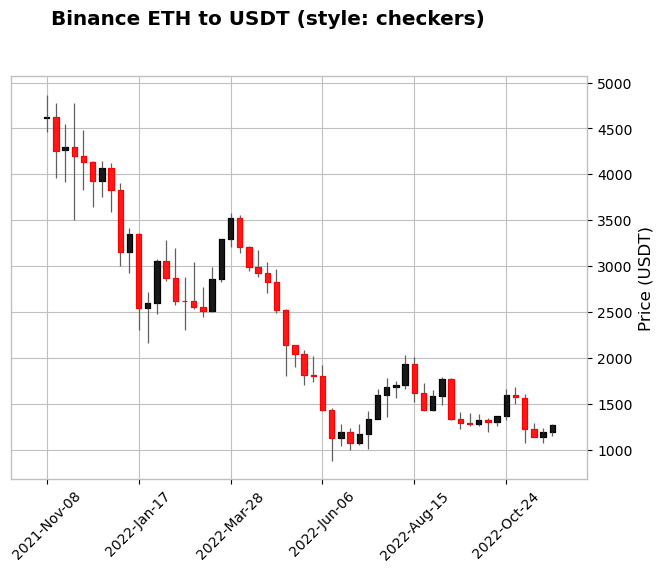

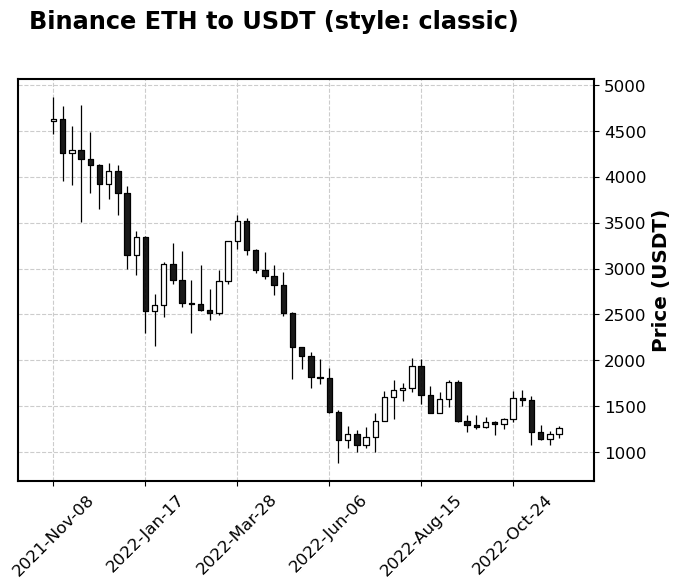

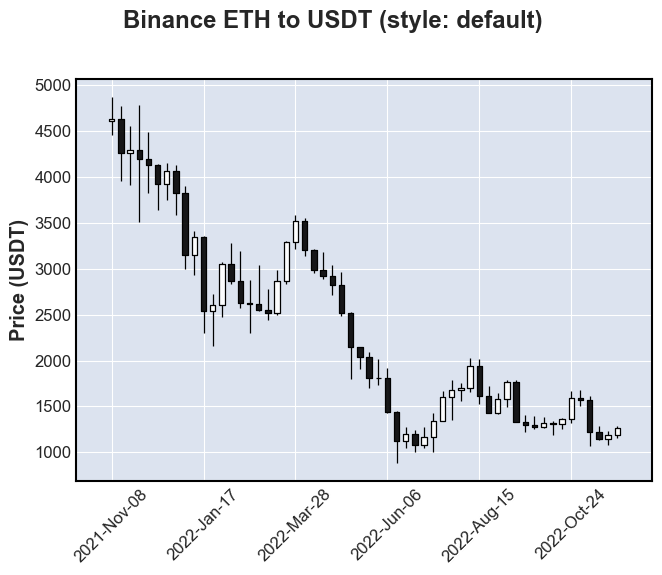

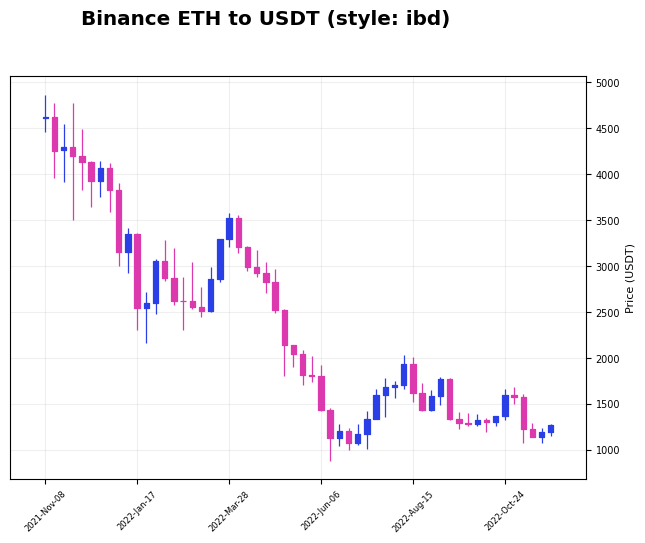

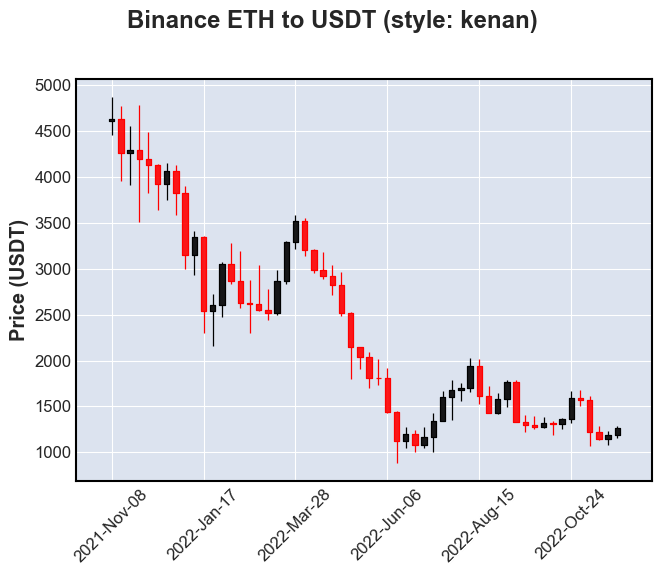

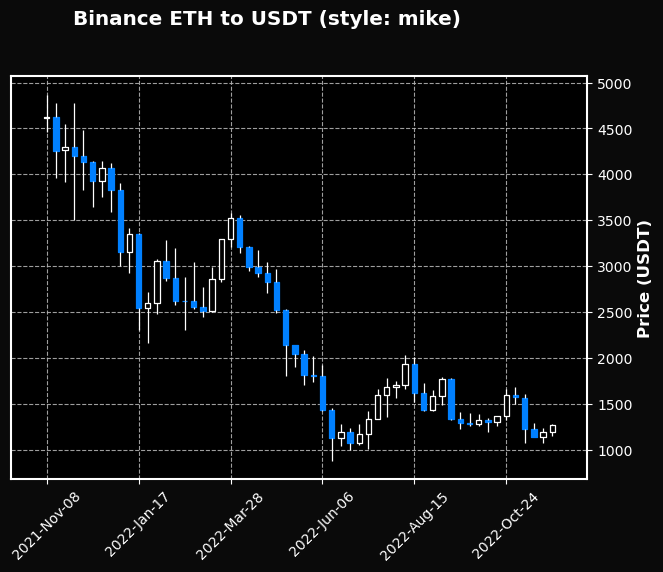

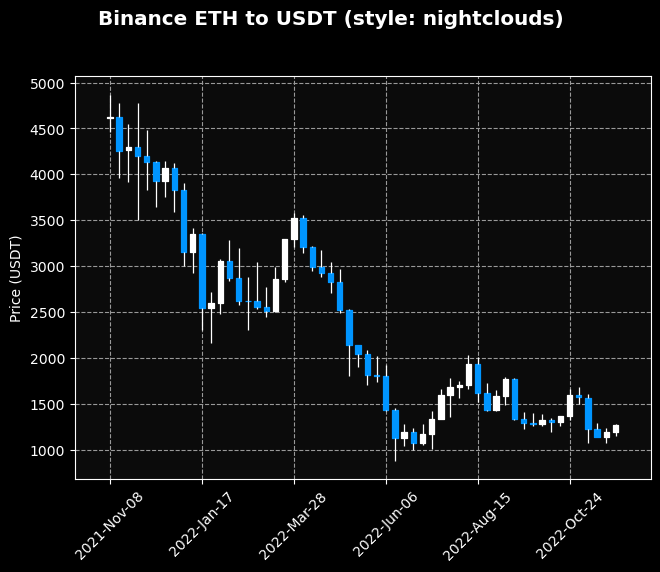

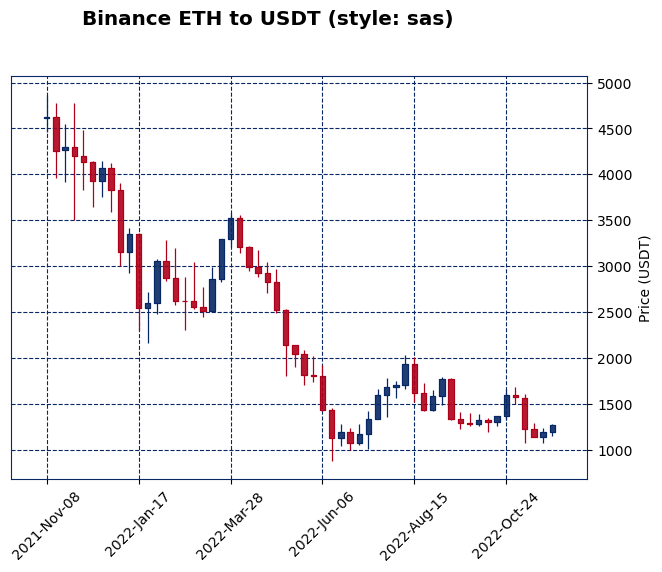

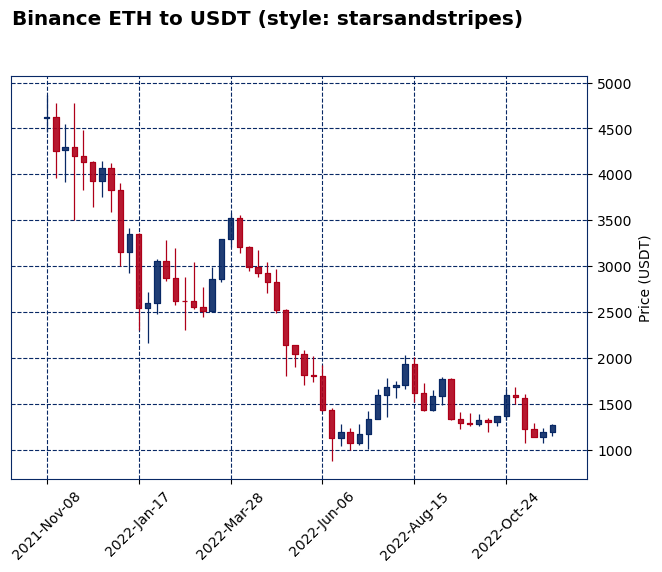

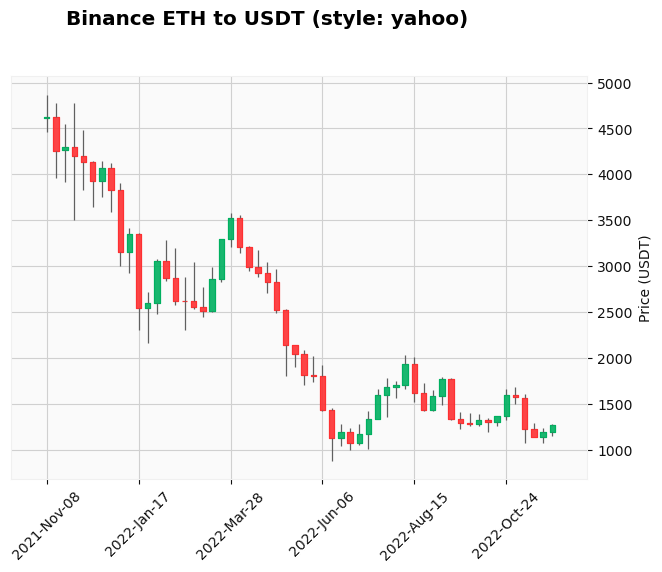

In [34]:
for style in fplt.available_styles():
    fplt.plot(
            df[-56:],
            type='candle',
            style=style,
            title='Binance ETH to USDT (style: {})'.format(style),
            ylabel='Price (USDT)'
        )

The library is capable to add the volume as part of the chart.

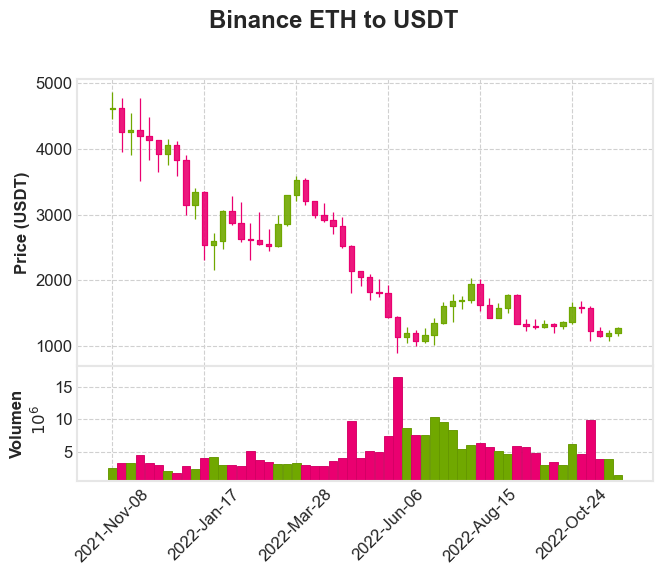

In [37]:
fplt.plot(
    df[-56:],
    type='candle',
    style='binance',
    title='Binance ETH to USDT',
    ylabel='Price (USDT)',
    volume=True,
    ylabel_lower='Volumen'
)

We can enable to show non trading events. The chart did't change because we have volume data in the shown events.

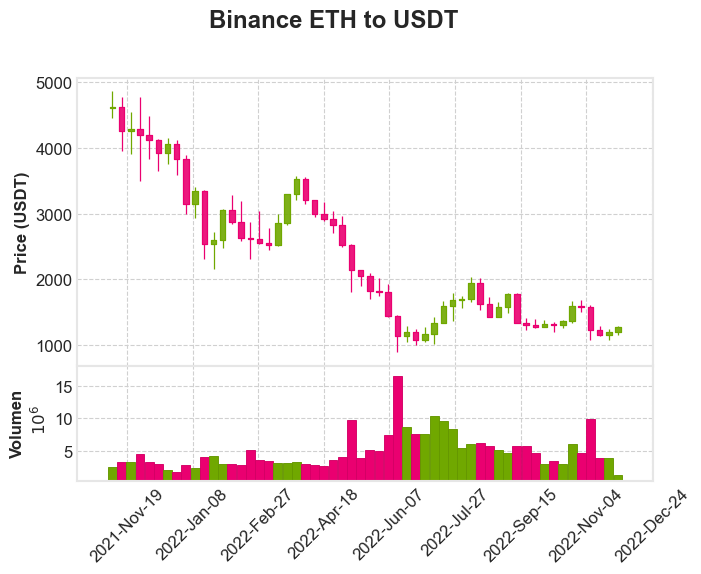

In [38]:
fplt.plot(
    df[-56:],
    type='candle',
    style='binance',
    title='Binance ETH to USDT',
    ylabel='Price (USDT)',
    volume=True,
    ylabel_lower='Volumen',
    show_nontrading=True
)

We add our own colors and styles, even include mobile average with different sizes (2,4,6).

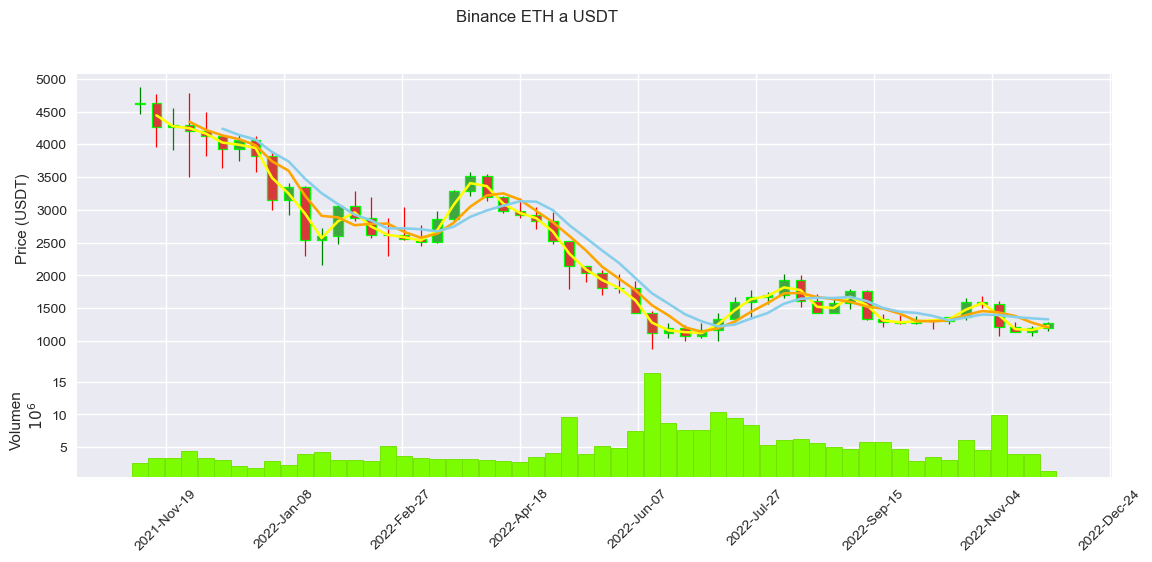

In [39]:
# our custom colors
mc = fplt.make_marketcolors(
                            up='tab:green',down='tab:red',
                            edge='lime',
                            wick={'up':'green','down':'red'},
                            volume='lawngreen',
                           )
# defining the style 
s  = fplt.make_mpf_style(base_mpl_style="seaborn", 
        marketcolors=mc, 
        mavcolors=["yellow","orange","skyblue"] # colors for Moving Average lines
    )
# plot with our custom style and adding Moving Average Lines
fplt.plot(
    df[-56:],
    type='candle',
    style=s,
    title='Binance ETH a USDT',
    ylabel='Price (USDT)',
    volume=True,
    ylabel_lower='Volumen',
    show_nontrading=True,
    figratio=(25,10),
    mav=(2,4,6)                   # Moving average lines value
)

##### 5.2 - Candlestick Charts with plotly

With plotly we can have an interactive candlestick chart with controls to zoom in and zoom out, it have hover events that shows you
the data information and so on.

To use it in a Jupyter Notebook, we have to set the `notebook_connected` as render so then we should be able to have the plot rendered
in the notebook with the interactive controls enabled.

In [42]:
import plotly.graph_objects as go
import plotly.io as pio
pio.renderers.default = "notebook_connected"

In [47]:
# x = df.index[-56:]
x = df.index
candlestick = go.Candlestick(
                x=x,
                open=df['open'],
                high=df['high'],
                low=df['low'],
                close=df['close'])
fig = go.Figure(data=[candlestick])
fig.update_layout(
    title="Binance ETH to USDT",
    yaxis_title="Price (USDT)"
)
mva_line = go.Scatter(x=x, y=df["open"], mode="lines", name="MVA")
fig.add_trace(mva_line)
fig.show()

## Problem Context


**Japanese candlestick patters:** The following definitions are stated in the context of univariate time series and standard Japanese candlesticks.


It is denoted by $J([s,t],n;X)$ to a **set** of $n$ japanese candlesticks in the time window between $s$ adn $t$, of the
time series $X$. When does't exists risk for confusion, $X$ is omitted. 

The **interval** fo each one of the $n$ candlesticks in $J([s,t],n)$ is given by $(t - s)/n$. Two sets of japanese candlestick with equal number of 
candlesticks, $J_{1}([s_{1},t_{1}],n)$ and $J_{2}([s_{2},t_{2}],n)$, they are said to be **similar**, if both meet some established criteria. The above 
is denoted by: $J_{1}([s_{1},t_{1}],n) \sim J_{2}([s_{2},t_{2}],n)$.

**Definition 1**. A **japanese candlestick pattern $\mathfrak{J}(n)$** is defined as an equivalence class of similar pattern set of $n$ japanese candlesticks. If in the similarity criteria for **$\mathfrak{J}(n)$** is established that the candlesticks in similar patterns, 
$J_{1}([s_{1},t_{1}],n) \sim J_{2}([s_{2},t_{2}],n)$, must have same interval $(t_{1}-s_{1})/n = (t_{2}-s_{2})/n$, the is denoted 
by $\mathfrak{J}(n,\tau)$ by said pattern, where $\tau = (t_{i} - s_{i})/n$ is the common value of the interval of the candlesticks in all the sets of  similar candlestick. 

The below definition can be paraphrased as follows:

$$
\mathfrak{J}(n) := \{J([s_{i}, t_{i}], m_{i};
X_i) \mid m_{i} = n \}/\sim,
$$
$$
\mathfrak{J}(n, \tau) := \{J([s_{i}, t_{i}], m_{i}; X{i}i) \mid m_{i} = n\ \ \& \ \ (t_{i} - s_{i})/n = \tau \}/\sim.
$$

#### 6 - Definitions in the Financial Context.

##### Technical Analysis


##### Fundamental Analysis

##### Trading Algorithm

#### 7 - Definitions in the Financial Context.